## Import libraries

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy
import numpy as np
from sklearn.preprocessing import StandardScaler

from pyrolite.comp import pyrocomp
import optuna
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.signal import savgol_filter
import scipy.stats as st
import seaborn as sns
import lightgbm
from lightgbm import LGBMRegressor
import random
import time
import sklearn
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

from sys import stdout
from sklearn.decomposition import PCA
from sklearn.utils import resample
 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.preprocessing import StandardScaler
import xgboost 
from sklearn.ensemble import RandomForestRegressor

from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# Affichage des versions
print(f'pandas version: {pd.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'numpy version: {np.__version__}')
print(f'optuna version: {optuna.__version__}')
print(f'scipy version: {scipy.__version__}')
print(f'seaborn version: {sns.__version__}')
print(f'lightgbm version: {lightgbm.__version__}')
print(f'scikit-learn version: {sklearn.__version__}')
print(f'xgboost version: {xgboost.__version__}')


pandas version: 2.1.4
matplotlib version: 3.8.0
numpy version: 1.26.4
optuna version: 3.6.1
scipy version: 1.11.4
seaborn version: 0.12.2
lightgbm version: 4.3.0
scikit-learn version: 1.2.2
xgboost version: 2.0.3


## Codes for hyperparameters optimization

In [38]:
# Define a custom scoring function using r2_score between actual and predicted data
def custom_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Objective function for RandomForestRegressor
def objective_rfr(trial):
    param = {
        'random_state': 48,
        'n_estimators': trial.suggest_int('n_estimators', 2, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 50),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 1.0),
    }

    regressor_obj = RandomForestRegressor(**param)
    
    # Use 5-fold cross-validation on the training set
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))

    # Store training R² in user attributes of trial
    trial.set_user_attr(key='train_r2', value=scores.mean())

    # Return the mean of the cross-validation scores
    return scores.mean()

# Objective function for XGBRegressor
def objective_xgbr(trial):
    ## Define search space for hyperparameters
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),  
        'gamma': trial.suggest_float("gamma", 0, 2),  
        'learning_rate': trial.suggest_float("eta", 0.01, 0.03),  
        'subsample': trial.suggest_float("subsample", 0.6, 0.9),  
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),  
        'lambda': trial.suggest_float("lambda", 1e-1, 1000),  
        'alpha': trial.suggest_float("alpha", 1e-1, 1000),  
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 0.9)  
    }

    regressor_obj = xgboost.XGBRegressor(**param)

    # Use 5-fold cross-validation on the training set
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))

    # Store training R² in user attributes of trial
    trial.set_user_attr(key='train_r2', value=scores.mean())

    # Return the mean of the cross-validation scores
    return scores.mean()

# Objective function for LGBMRegressor
def objective_lgbr(trial):
    param = {
        'metric': 'mae',
        'random_state': 48,
        'n_estimators': trial.suggest_int('n_estimators', 2, 75),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-1, 1000),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4, 0.5, 0.6]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'num_leaves': trial.suggest_int('num_leaves', 2, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
    }

    regressor_obj = LGBMRegressor(**param)

    # Use 5-fold cross-validation on the training set
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))

    # Store training R² in user attributes of trial
    trial.set_user_attr(key='train_r2', value=scores.mean())

    # Return the mean of the cross-validation scores
    return scores.mean()

# Objective function for Support Vector Regressor
def objective_svr(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
    param = {
        'kernel': kernel,
        'C': trial.suggest_loguniform('C', 0.1, 1),  
        'epsilon': trial.suggest_loguniform('epsilon', 1e-2, 1) 
    }

    if kernel == "rbf":
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-4, 0.1) 

    regressor_obj = SVR(**param)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring='r2')

    trial.set_user_attr(key='train_r2', value=scores.mean())

    return scores.mean()

# Objective function for PLSRegression
def objective_plsr(trial):
    param = {
        'n_components': trial.suggest_int('n_components', 2, 8),
        'tol': trial.suggest_float('tol', 1e-8, 1e-2),
        'scale': trial.suggest_categorical('scale', [True, False])
    }

    regressor_obj = PLSRegression(**param)

    # Use 5-fold cross-validation on the training set
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))

    # Store training R² in user attributes of trial
    trial.set_user_attr(key='train_r2', value=scores.mean())
    # Return the mean of the cross-validation scores
    return scores.mean()


## Import datasets

In [45]:
#data = pd.read_csv (r'path_to_file\file.csv')
data = pd.read_csv (r'I:\Phd\Articles\Resistivity_Inversion\Data\Logs_Basement.csv')
data = data.loc[data['RLLD'] > 0]
geochem = data.loc[:, 'Ag':'Filler'] ## Supposing geochem columns go from "Ag" to "Filler"
spectral = data.loc[:, '500':'2400'] ## Select wavelengths associated to IR and storing them in another dataframe.

wvl = np.arange(350, 2498, 1)

## Load IR spectra already processed using continuum removal
removed_spectra = np.load(r'I:\Phd\Articles\Resistivity_Inversion\Data\Clean_Data\CR_Spectra_BST.npy')
removed_spectra = pd.DataFrame (removed_spectra, columns = wvl)
data_cr = pd.concat ([data.loc[:, 'HoleName':'Filler'], removed_spectra], axis = 1, sort = False)

## Blind well train-test split

In [46]:
## Separation of an external dataset. In the presented paper, this was made by separating all samples belonging to the 'GET' (Getty Russell) project. 
data_ml = data.loc[data['Project'] != 'GET']
data_get = data.loc[data['Project'] == 'GET']

## Select 1/4 drillholes for the testing, 3/4 for the training
holenames = data_ml['HoleName'].unique().tolist()
num_elements_to_select = int(len(holenames) * 25 / 100)
testing_holenames = random.sample(holenames, num_elements_to_select)
training_holenames = [name for name in holenames if name not in testing_holenames]

## For the split presented in the article, use instead:
testing_holenames = pd.read_csv (r'I:\Phd\Articles\Resistivity_Inversion\Data\Train_Test_Split\Testing_HoleNames.csv').iloc[:, 1].tolist()
training_holenames = pd.read_csv (r'I:\Phd\Articles\Resistivity_Inversion\Data\Train_Test_Split\Training_HoleNames.csv').iloc[:, 1].tolist()
testing_data = data_ml[data_ml['HoleName'].isin(testing_holenames)]
training_data = data_ml[data_ml['HoleName'].isin(training_holenames)]

## Pre-processing

### Geochemistry

In [47]:
###
### Pre-processing for the training dataset
###

geochem_training = training_data.loc[:, 'Ag':'Filler'] ## Select geochemical data from the training dataset
## Three scenarios for geochemical data were tested : isometric log-ratio (ILR), centered log-ratio (CLR) and pairwise log-ratio (PWLR)
## ILR and CLR are already available through the pyrocomp library. PWLR is defined in this code snippet. Each of the three scenarios is 
## then stored in a specific dataframe

#geochem_ilr_training = geochem_training.pyrocomp.ILR()
geochem_clr_training = geochem_training.pyrocomp.CLR()
geochem_clr_training = geochem_clr_training.reset_index(drop=True)

## PWLR
element_pairs = [(element1, element2) for element1 in geochem_training.columns for element2 in geochem_training.columns if element1 < element2]
geochem_pwlr_training = pd.DataFrame(index=geochem_training.index)

# Compute pwlr
for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_training[element1] / geochem_training[element2])
    geochem_pwlr_training[log_ratio_column] = log_ratios
geochem_pwlr_training = geochem_pwlr_training.reset_index(drop=True)
## geochem_clr_training, geochem_pwlr_training and geochem_ilr_training are stored. 

### Pre-processing of geochemical data for the testing dataset
geochem_testing = testing_data.loc[:, 'Ag':'Filler']
#geochem_ilr_testing = geochem_testing.pyrocomp.ILR()
geochem_clr_testing = geochem_testing.pyrocomp.CLR()
geochem_clr_testing = geochem_clr_testing.reset_index(drop=True)

## PWLR
element_pairs = [(element1, element2) for element1 in geochem_testing.columns for element2 in geochem_testing.columns if element1 < element2]
geochem_pwlr_testing = pd.DataFrame(index=geochem_testing.index)

# Compute pwlr
for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_testing[element1] / geochem_testing[element2])
    geochem_pwlr_testing[log_ratio_column] = log_ratios
geochem_pwlr_testing = geochem_pwlr_testing.reset_index(drop=True)

### IR spectroscopy

In [48]:
ir_training_cr = training_data.loc[:, '1000':'2400']
ir_training_ss = pd.DataFrame(savgol_filter(ir_training_cr, 25, polyorder = 2, deriv = 0))
ir_training_fod = pd.DataFrame(savgol_filter(ir_training_cr, 25, polyorder = 2, deriv = 1))
ir_training_sod = pd.DataFrame(savgol_filter(ir_training_cr, 25, polyorder = 2, deriv = 2))

ir_testing_cr = testing_data.loc[:, '1000':'2400']
ir_testing_ss = pd.DataFrame(savgol_filter(ir_testing_cr, 25, polyorder = 2, deriv = 0))
ir_testing_fod = pd.DataFrame(savgol_filter(ir_testing_cr, 25, polyorder = 2, deriv = 1))
ir_testing_sod = pd.DataFrame(savgol_filter(ir_testing_cr, 25, polyorder = 2, deriv = 2))


## Choice of scenario

In [51]:
## When using data fusion, uncomment this and include the different scenarios in X_train
#X_train = StandardScaler().fit_transform(pd.concat([geochem_pwlr_training, ir_training], axis=1))
#X_test = StandardScaler().fit_transform(pd.concat([geochem_pwlr_testing, ir_testing], axis=1))

## Standardize all variables and hoose the scenario to be used
X_train = StandardScaler().fit_transform(geochem_clr_training) ## ir_training_cr, ir_training_sod, geochem_clr_training,...
X_test = StandardScaler().fit_transform(geochem_clr_testing)
#{X_train.columns = X_train.columns.astype(str)
#X_test.columns = X_test.columns.astype(str)

## Define the target variable. In our case, target variable was resistivity (RLLD) taken as log values
y_train = np.log10(training_data['RLLD']) ## commenter cette ligne pour le train-test aléatoire
y_test = np.log10(testing_data['RLLD']) ## commenter cette ligne pour le train-test aléatoire



## Training

In [52]:
# models and their corresponding objective functions
models = [
    ('LGBR', objective_lgbr),
    ('XGBR', objective_xgbr),
    ('RFR', objective_rfr),
    ('SVR', objective_svr),
    ('PLSR', objective_plsr),
]

best_trials = {}
n_jobs = 8  # number of workers to be used (physical cores on CPU)
n_trials = 100 # Number of optuna trials. Each optuna trial fits the model once using hyperparameters in the range defined by the objective function

## Lists to store R² and RMSE on the training and validation datasets
train_r2_results = []
test_r2_results = []
train_rmse_results = []
test_rmse_results = []

# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    train_rmse = mean_squared_error(y_train, train_preds, squared=False)
    test_rmse = mean_squared_error(y_test, test_preds, squared=False)
    
    return train_r2, test_r2, train_rmse, test_rmse

## Function to run models using objective functions
for model_name, objective_function in models:
    print(model_name)

    progress_bar = tqdm(total=n_trials, position=0, leave=True, desc=model_name,
                       bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

    def objective_with_progress_bar(trial):
        result = objective_function(trial)
        progress_bar.update(1)
        return result

    start_time = time.time()
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_with_progress_bar, n_trials=n_trials, n_jobs=n_jobs)
    end_time = time.time()
    best_trials[model_name] = study.best_trial
    optuna.logging.set_verbosity(optuna.logging.INFO)
    progress_bar.close()

    total_time = end_time - start_time
    print(f"{model_name} took {total_time:.2f} seconds")

    trial = study.best_trial
    print(f"Best trial parameters for {model_name}: {trial.params}")
    print(f"Best trial CV R² for {model_name}: {trial.value:.4f}")

    if model_name == 'PLSR':
        model = PLSRegression(n_components=trial.params['n_components'])
    elif model_name == 'LGBR':
        model = LGBMRegressor(**trial.params)
    elif model_name == 'XGBR':
        model = xgboost.XGBRegressor(**trial.params)
    elif model_name == 'RFR':
        model = RandomForestRegressor(**trial.params)
    elif model_name == 'SVR':
        model = SVR(**trial.params)

    train_r2, test_r2, train_rmse, test_rmse = evaluate_model(model, X_train, y_train, X_test, y_test)
    
    print(f"{model_name} - Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"{model_name} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}\n")

    train_r2_results.append(train_r2)
    test_r2_results.append(test_r2)
    train_rmse_results.append(train_rmse)
    test_rmse_results.append(test_rmse)

# Display summary tables for performance metrics
print("\nSummary of Results:")
print("Model\t\tTrain R²\tTest R²\t\tTrain RMSE\tTest RMSE")
print("----------------------------------------------------------------")
for i, model_name in enumerate([name for name, _ in models]):
    print(f"{model_name}\t\t{train_r2_results[i]:.4f}\t\t{test_r2_results[i]:.4f}\t\t{train_rmse_results[i]:.4f}\t\t{test_rmse_results[i]:.4f}")

LGBR


LGBR: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00]


LGBR took 14.10 seconds
Best trial parameters for LGBR: {'n_estimators': 73, 'reg_alpha': 0.13128028007442571, 'reg_lambda': 0.04922938922739757, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.04701522938029518, 'max_depth': 5, 'num_leaves': 8, 'min_child_samples': 28}
Best trial CV R² for LGBR: 0.7875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 51
[LightGBM] [Info] Start training from score 3.223008
LGBR - Train R²: 0.8699, Test R²: 0.7886
LGBR - Train RMSE: 0.2781, Test RMSE: 0.3726

XGBR


XGBR: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00]


XGBR took 27.41 seconds
Best trial parameters for XGBR: {'max_depth': 5, 'gamma': 1.3574085560597822, 'eta': 0.022296664474080925, 'subsample': 0.8900059027216759, 'min_child_weight': 5, 'lambda': 57.94466754288868, 'alpha': 34.923636106810925, 'colsample_bytree': 0.7733082156518004}
Best trial CV R² for XGBR: 0.6006
XGBR - Train R²: 0.6573, Test R²: 0.6187
XGBR - Train RMSE: 0.4515, Test RMSE: 0.5005

RFR


RFR: 100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00]


RFR took 16.46 seconds
Best trial parameters for RFR: {'n_estimators': 8, 'max_depth': 9, 'max_leaf_nodes': 30, 'min_samples_split': 0.14652188746157258, 'min_samples_leaf': 0.10081672511724932}
Best trial CV R² for RFR: 0.6671
RFR - Train R²: 0.6884, Test R²: 0.6651
RFR - Train RMSE: 0.4304, Test RMSE: 0.4690

SVR


SVR: 100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00]


SVR took 11.99 seconds
Best trial parameters for SVR: {'kernel': 'rbf', 'C': 0.9985038882653322, 'epsilon': 0.013458682345657823, 'gamma': 0.019759649828765487}
Best trial CV R² for SVR: 0.8267
SVR - Train R²: 0.9465, Test R²: 0.7844
SVR - Train RMSE: 0.1784, Test RMSE: 0.3763

PLSR


PLSR: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00]

PLSR took 6.63 seconds
Best trial parameters for PLSR: {'n_components': 8, 'tol': 0.0024017381478083255, 'scale': True}
Best trial CV R² for PLSR: 0.7670
PLSR - Train R²: 0.7917, Test R²: 0.7474
PLSR - Train RMSE: 0.3519, Test RMSE: 0.4073


Summary of Results:
Model		Train R²	Test R²		Train RMSE	Test RMSE
----------------------------------------------------------------
LGBR		0.8699		0.7886		0.2781		0.3726
XGBR		0.6573		0.6187		0.4515		0.5005
RFR		0.6884		0.6651		0.4304		0.4690
SVR		0.9465		0.7844		0.1784		0.3763
PLSR		0.7917		0.7474		0.3519		0.4073


## Prediction intervals

<class 'sklearn.cross_decomposition._pls.PLSRegression'>


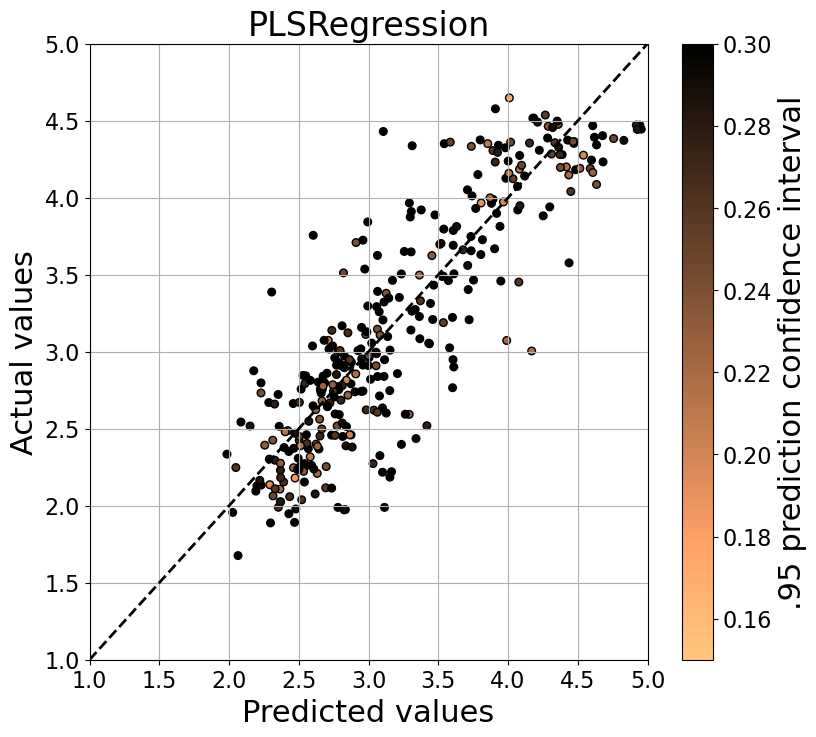

<class 'xgboost.sklearn.XGBRegressor'>


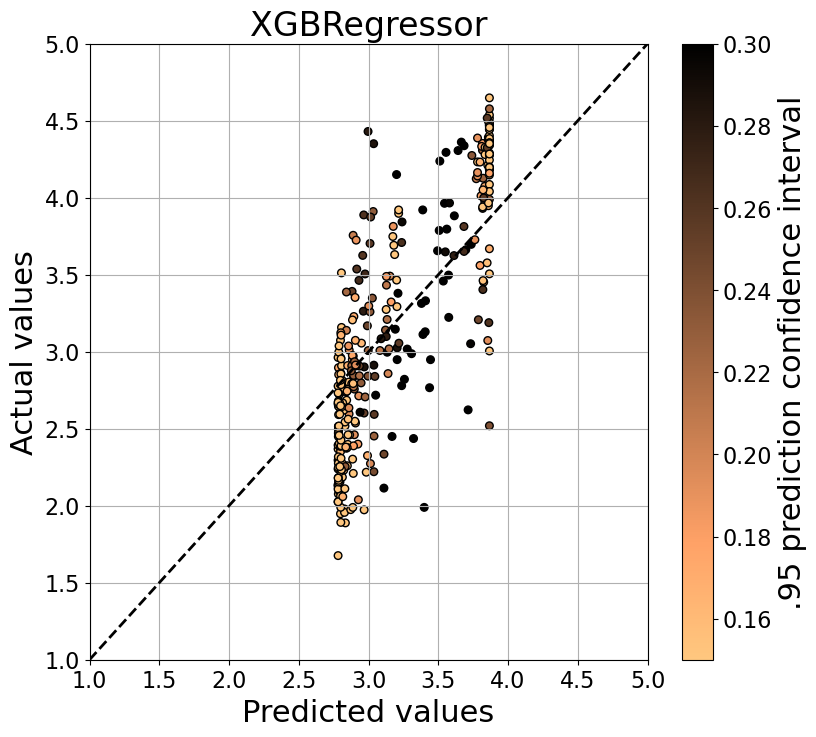

<class 'sklearn.ensemble._forest.RandomForestRegressor'>


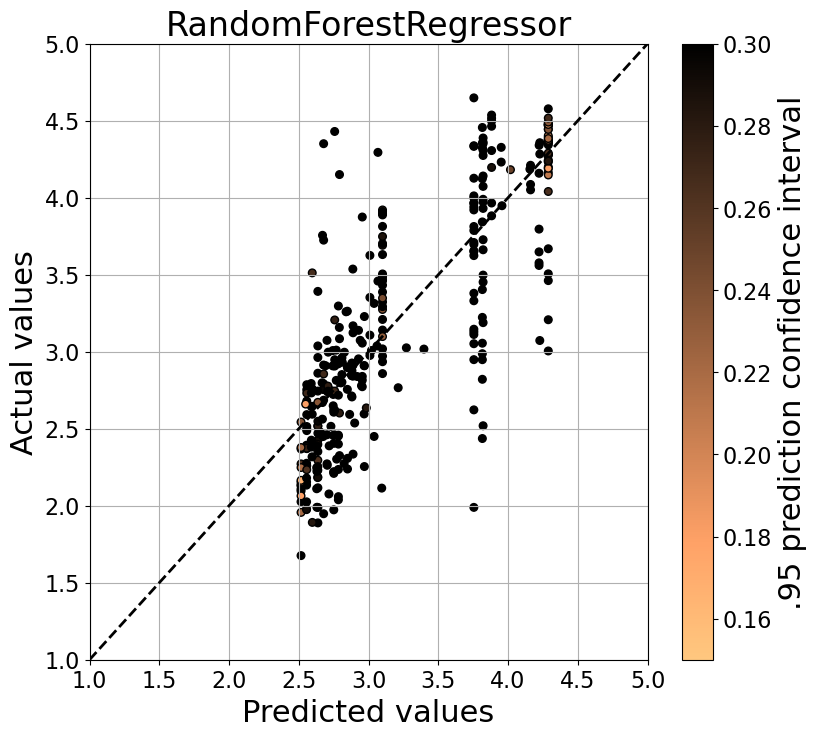

<class 'sklearn.svm._classes.SVR'>


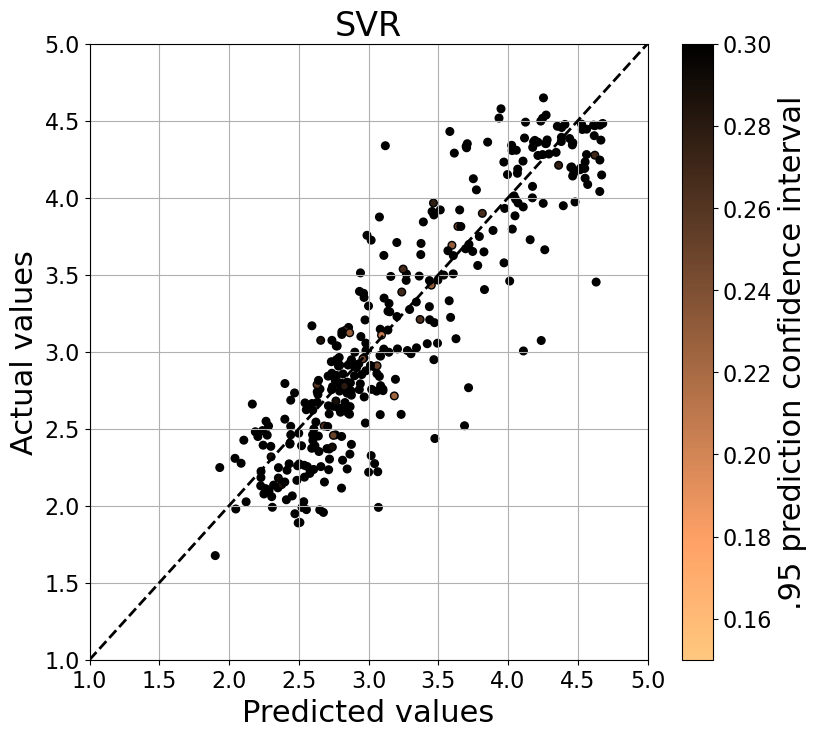

<class 'lightgbm.sklearn.LGBMRegressor'>
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12911
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 51
[LightGBM] [Info] Start training from score 3.215590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12864
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 51
[LightGBM] [Info] Start training from score 3.244604
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 800, number of used fe

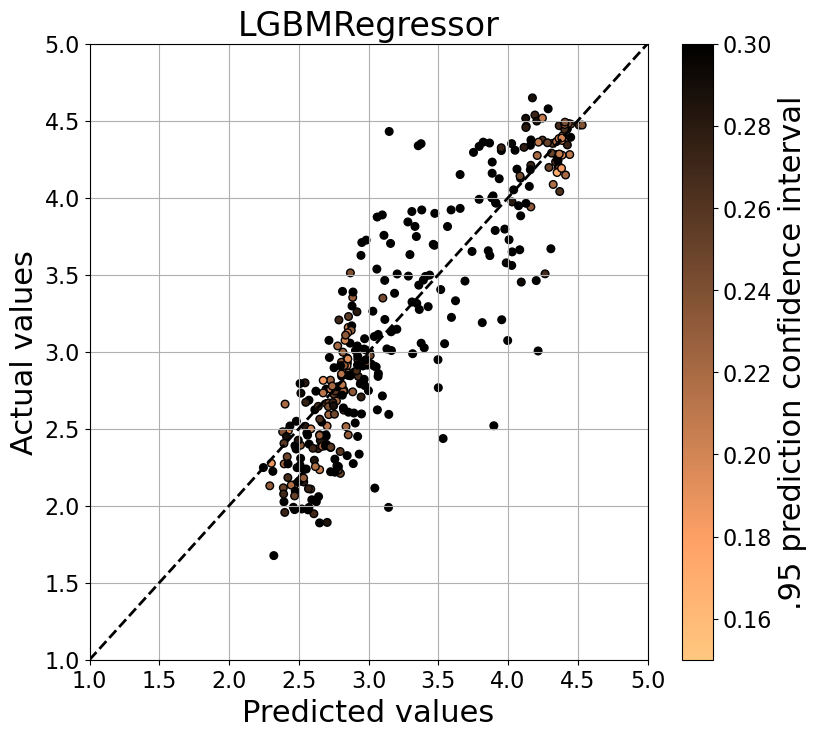

In [54]:
# Function to run bootstrap on a given model, here by randomly selecting 800 samples from the training dataset
def run_bootstrap(model_class, model_name, best_params, X_train, y_train, X_test, y_test, n_iterations=100, n_samples=400): 
    model = model_class(**best_params)
    print(str(model_class))
    y_bootstrap = []

    for i in range(n_iterations):
        X_bs, y_bs = resample(X_train, y_train, replace=True, n_samples=n_samples)
        model.fit(X_bs, y_bs)
        y_hat = model.predict(X_test)
        
        y_hat = y_hat.flatten()
        
        y_bootstrap.append(y_hat)

    y_bootstrap = np.vstack(y_bootstrap)
    uncertainty = pd.DataFrame(y_bootstrap).std(axis=0)
    mean = pd.DataFrame(y_bootstrap).mean(axis=0) ## get mean value of prediction for each sample. 
    y_hat = model.predict(X_test).flatten()

    ## Obtain upper and lower values of confidence intervals at 95% as 1.96 std
    upper_ci = mean + (1.96 * uncertainty)
    lower_ci = mean - (1.96 * uncertainty)
    ci_difference = upper_ci - lower_ci

    diff = pd.DataFrame(ci_difference, columns=['CI']).reset_index()
    y1 = pd.DataFrame(y_hat, columns=['Predicted']).reset_index()
    y2 = pd.DataFrame(y_test).reset_index()
    matrix = pd.concat([diff, y1, y2], sort=False, axis=1)

    ## Draw scatterplot of predicted vs actual values, colored by confidence intervals
    plt.figure(figsize=(9, 8))
    plt.xlabel('Predicted values', fontsize=22)
    plt.ylabel('Actual values', fontsize=22)
    plt.grid(True)
    plt.scatter(matrix['Predicted'], matrix['RLLD'], c=matrix['CI'], cmap='copper_r', vmin=0.15, vmax=0.3, marker='o', s=30, edgecolor='black', linewidth=1)

    clb = plt.colorbar()
    clb.set_label('.95 prediction confidence interval', fontsize=22)
    clb.ax.tick_params(labelsize=16)  
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(1, 5)
    plt.ylim(1, 5)
    plt.title(model_name, fontsize=24)
    plt.plot([1, 5], [1, 5], linestyle='--', color='black', linewidth=2, label='y=x')
    
    plt.show()

# Extract parameters correctly from best_trials
best_params_plsr = best_trials['PLSR'].params
best_params_svr = best_trials['SVR'].params
best_params_rfr = best_trials['RFR'].params
best_params_lgbr = best_trials['LGBR'].params
best_params_xgbr = best_trials['XGBR'].params

# Run the bootstrap and plot for each model
run_bootstrap(PLSRegression, 'PLSRegression', best_params_plsr, X_train, y_train, X_test, y_test)
run_bootstrap(xgboost.XGBRegressor, 'XGBRegressor', best_params_xgbr, X_train, y_train, X_test, y_test)
run_bootstrap(RandomForestRegressor, 'RandomForestRegressor', best_params_rfr, X_train, y_train, X_test, y_test)
run_bootstrap(SVR, 'SVR', best_params_svr, X_train, y_train, X_test, y_test)
run_bootstrap(LGBMRegressor, 'LGBMRegressor', best_params_lgbr, X_train, y_train, X_test, y_test)

## Feature importance

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 51
[LightGBM] [Info] Start training from score 3.223008


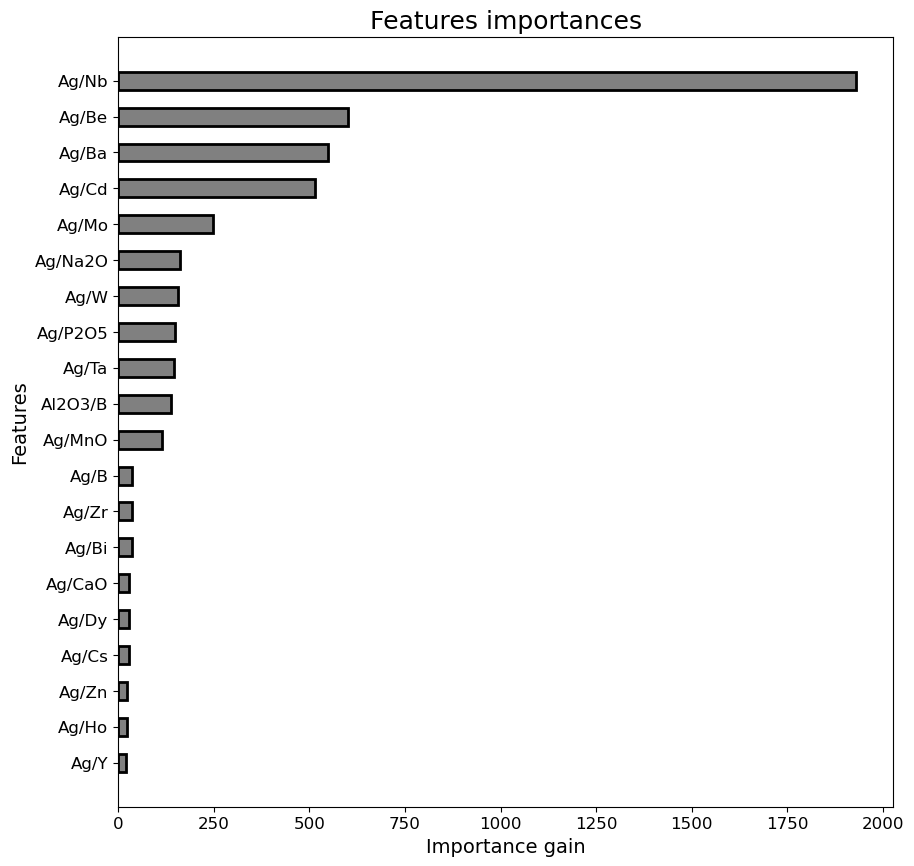

In [55]:
## Feature importance

best_model = LGBMRegressor (**best_trials['LGBR'].params)
best_model.fit (X_train, y_train)

# Get feature importance values
features = pd.concat([ geochem_pwlr_training], axis=1)
features.columns = features.columns.astype(str)

feature_names = features.columns
importance_values = best_model.booster_.feature_importance(importance_type='gain')

# Sort features by importance
sorted_indices = np.argsort(importance_values)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance_values = [importance_values[i] for i in sorted_indices]

# Plot bar chart for features importances
fig, ax = plt.subplots(figsize=(10, 10))

bar_colors = 'grey'
bar_height = 0.5  # Adjust the height as needed

ax.barh(sorted_feature_names[:20][::-1], sorted_importance_values[:20][::-1], color=bar_colors, height=bar_height, edgecolor='black', linewidth=2)

# Customize the plot
ax.set_title('Features importances', fontsize=18) 
ax.set_xlabel('Importance gain', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)
plt.show()

## Prediction on the external dataset

In [59]:
## Preprocessing on the external dataset
# As the external dataset was separated prior to train-test split, it needs first to be preprocessed before using the model on it. 

## IR spectroscopy
ir_get_cr = data_get.loc[:, '1000':'2400']
ir_get_ss = pd.DataFrame(savgol_filter(ir_get_cr, 25, polyorder = 2, deriv = 0))
ir_get_fod = pd.DataFrame(savgol_filter(ir_get_cr, 25, polyorder = 2, deriv = 1))
ir_get_sod = pd.DataFrame(savgol_filter(ir_get_cr, 25, polyorder = 2, deriv = 2))

## Geochemical data
geochem_get = data_get.loc[:, 'Ag':'Filler']

## PWLR
element_pairs = [(element1, element2) for element1 in geochem_get.columns for element2 in geochem_get.columns if element1 < element2]
geochem_pwlr_get = pd.DataFrame(index=geochem_get.index)
geochem_clr_get = geochem_get.pyrocomp.CLR()

# Compute pwlr
for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_get[element1] / geochem_get[element2])
    geochem_pwlr_get[log_ratio_column] = log_ratios

X_get = geochem_clr_get
X_get.columns = X_get.columns.astype(str)
X_get = StandardScaler().fit_transform(X_get)

## Define target variable
y_get = np.log10(data_get['RLLD'])

####
pd.DataFrame(X_get)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.133956,1.381727,0.924444,0.253762,-0.186073,0.390057,-1.894485,1.087487,1.541657,-1.314537,...,1.728514,-0.375900,0.993589,-0.462034,0.764902,-2.072199,-1.186996,-1.950792,1.242246,3.436962
1,-1.263084,1.861717,0.737396,0.380370,0.575431,0.244898,-1.998929,0.923304,1.808053,-1.336169,...,2.461436,-0.137850,-0.477291,-0.512404,0.638695,-2.669829,-1.631126,-0.736930,1.501771,3.202591
2,0.989377,0.613758,0.592101,0.171125,-0.741509,0.039891,-2.146435,0.691430,0.974063,-1.790431,...,1.460314,-0.382042,0.805586,-0.806542,0.766263,0.865788,-0.261431,-0.985088,2.040318,2.976650
3,-0.374509,-1.183541,0.513464,-0.587093,-0.237767,-1.172643,0.699328,-0.961534,0.894270,0.149105,...,1.747092,-0.306744,0.557641,0.182856,-0.472039,1.852089,0.704566,-0.509755,-0.721075,-0.759588
4,1.120699,-0.165573,0.679607,-0.635790,0.100163,-0.877950,-0.897722,-0.628221,0.662976,0.737275,...,0.818750,0.896862,-0.487696,0.743500,-0.214683,0.227102,0.145795,0.965253,0.222422,-0.474887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.026135,-1.109758,-0.421160,-0.873242,-0.604132,1.474291,-0.576450,-0.521163,0.313016,0.515441,...,-0.538874,0.195285,0.151329,0.315157,0.277058,0.870182,1.022515,1.762125,-0.485812,-1.046322
249,-1.352492,-1.140909,-0.781358,1.127401,-0.843611,0.004081,-1.229891,-1.150378,0.279004,-0.104984,...,0.001411,-0.148931,0.482396,0.724202,-0.115830,-0.008549,-0.101820,0.909283,-0.490484,-1.182781
250,-0.851653,-1.021197,-0.925854,0.545914,-1.189534,1.579359,0.104308,-1.034189,0.131897,0.452192,...,-0.269159,-0.115509,0.235302,0.778517,-0.333396,-0.120923,-0.150456,-0.655834,-0.732366,-1.050919
251,-1.611812,-1.410353,-1.395432,0.031434,-1.591539,1.325824,1.570125,0.198832,0.048161,1.734277,...,-0.945457,-0.489605,-2.079952,0.161979,-0.554809,0.889356,0.884005,1.836553,-1.622961,-0.454054


In [60]:
## Prediction on the external dataset

best_params = {'n_estimators': 72, 'reg_alpha': 0.14002824939901107, 'reg_lambda': 0.006438311069718575, 'colsample_bytree': 0.4, 'subsample': 0.4, 
               'learning_rate': 0.04757491442812937, 'max_depth': 9, 'num_leaves': 9, 'min_child_samples': 13}
best_model = LGBMRegressor (**best_params)
best_model.fit (X_train, y_train)

y_c = pd.DataFrame(best_model.predict(X_get))

y_c.columns = ['Predicted_values']
print(len(y_c))
## Uncertainty prediction

y_bootstrap_get = []
# bootstrap predictions
accuracy = []
n_iterations = 100
for i in range(n_iterations):
    X_bs, y_bs = resample(X_train, y_train, replace=True, n_samples = 400)
    best_model.fit(X_bs,y_bs)
    # make predictions
    y_hat = best_model.predict(X_get)
    print(i)
    y_bootstrap_get.append(y_hat)
    
y_bootstrap_get = pd.DataFrame(np.vstack(y_bootstrap_get))

##
uncertainty = pd.DataFrame(y_bootstrap_get).std(axis = 0)
mean = pd.DataFrame(y_bootstrap_get).mean(axis = 0)
y_hat = best_model.predict(X_get)
print(len(y_hat))
upper_ci = mean + 1.96 * uncertainty
lower_ci = mean - 1.96 * uncertainty
ci_difference = upper_ci - lower_ci


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 51
[LightGBM] [Info] Start training from score 3.223008
253
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12946
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 51
[LightGBM] [Info] Start training from score 3.218360
0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12940
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 51
[LightGBM] [Info] Star

## Formatting and export for synthetic logs

In [36]:
## The obtained predictions and their confidence intervals on the external dataset are then concatenated to the external dataset and exported. 
## Using graphical tools, one can then redraw synthetic logs with actual and predicted values to assess the ability of the model to cover his needs. 

actual_values = np.log10(data_get['RLLD'])
predicted_values = y_c
min_ci = pd.DataFrame(lower_ci, columns = ['Lower_CI'])
max_ci = pd.DataFrame(upper_ci, columns = ['Upper_CI'])
collar = data_get.loc[:, 'HoleName':'SAMPTO']

actual_values = actual_values.reset_index(drop = True)
predicted_values = predicted_values.reset_index(drop = True)
min_ci = min_ci.reset_index(drop = True)
max_ci = max_ci.reset_index(drop = True)
collar = collar.reset_index(drop = True)

prediction_get = pd.concat ([collar, actual_values, predicted_values, min_ci, max_ci], axis = 1, sort = False)

prediction_get

,HoleName,SAMPFROM,SAMPTO,RLLD,Predicted_values,Lower_CI,Upper_CI
0,GRL161A,38.7,60.0,3.747775,3.636053,3.420387,3.710834
1,GRL161A,60.0,80.0,3.649273,3.574536,3.378748,3.673128
2,GRL161A,80.0,100.0,3.175541,3.253983,3.177977,3.399962
3,GRL161A,100.0,120.0,3.170746,3.306248,3.248406,3.383559
4,GRL161A,120.0,140.0,3.202148,3.347497,3.264067,3.466807
...,...,...,...,...,...,...,...
293,GRL221,140.0,150.0,3.146670,3.686943,3.579011,3.773372
294,GRL221,150.0,160.0,3.239655,3.591416,3.354785,3.688731
295,GRL221,160.0,170.0,3.055152,3.312718,3.257895,3.437643
296,GRL221,170.0,180.0,3.167326,3.650630,3.574934,3.764802
